# IEG analysis

To identify paterns of IEG activation and which cell clusters are selectively activated by each input stimulation

### Library import

In [1]:
library(Seurat)
library(dplyr)
library(magrittr)
IRdisplay::display_html("<style> .container { width:95% !important; } </style>")
library("xlsx")

#for plotting
library("ggplot2")
library(reshape2)
library(ggrepel)
library(ggpubr)
library(tidyr)
library(cowplot)
library(svglite)
library(scales)

library(ggpubr)
library("RColorBrewer")
library(gplots)

Warning message:
"package 'Seurat' was built under R version 4.1.3"
Attaching SeuratObject

Attaching sp

Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'magrittr' was built under R version 4.1.3"


Warning message:
"package 'xlsx' was built under R version 4.1.3"
Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'reshape2' was built under R version 4.1.3"
Warning message:
"package 'ggrepel' was built under R version 4.1.3"
Warning message:
"package 'ggpubr' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"

Attaching package: 'tidyr'


The following object is masked from 'package:reshape2':

    smiths


The following object is masked from 'package:magrittr':

    extract


Warning message:
"package 'cowplot' was built under R version 4.1.3"

Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend


Warning message:
"package 'svglite' was built under R version 4.1.3"
Warning message:
"package 'scales' was built under R version 4.1.3"
Warning message:
"package 'gplots' was built under R version 4.1.3"

Attaching package: 'gplots'


The followi

### Loading in the data

In [2]:
VTA.integrated<-readRDS(file="./VTA_integrated.rds")
VTA_YFP <- readRDS(file = "./VTA_YFP.rds")
VTA_LH <- readRDS(file = "./VTA_LH.rds")
VTA_PFC <- readRDS(file = "./VTA_PFC.rds")
VTA_NAc <- readRDS(file = "./VTA_NAc.rds")

### Reassigning identities

In [3]:
#new.ident will redefine the cluster numbers to the labels below. 
new.ident <- c("Glu1","CoEx1","Gaba1","DA1","DA2","Gaba2","Glu2","Glu3","Glu4","DA3","Glu5","Glu6","Glu7","CoEx2","CoEx3","Gaba3","Gaba4")
names(x = new.ident) <- levels(x =VTA.integrated)
VTA.integrated<- RenameIdents(object =VTA.integrated, new.ident)

In [4]:
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(VTA.integrated@assays$RNA@data[,which(Idents(object=VTA.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
assign(paste(new.ident[i],"_barcode_VTA_YFP",sep=""),intersect(colnames(VTA_YFP@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_LH",sep=""),intersect(colnames(VTA_LH@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_NAc",sep=""),intersect(colnames(VTA_NAc@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_PFC",sep=""),intersect(colnames(VTA_PFC@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
}

In [5]:
barcode_names <- unique(paste(Idents(VTA.integrated),"_barcode",sep=""))

In [6]:
celltype<-vector()
for (i in 1:dim(VTA.integrated@meta.data)[1]){
    celltype[i]<-toString(new.ident[VTA.integrated@meta.data$integrated_snn_res.0.5[i]])
}
VTA.integrated@meta.data$celltype<-celltype

In [7]:
DefaultAssay(VTA.integrated) <- 'RNA'

### IEG volcano plot

In [8]:
IEG <- read.xlsx("./IEG list.xlsx",sheetIndex=1,header=FALSE)
IEG <-IEG$X1   
# removing genes that are not present in the dataset
all_genes <- unlist(VTA.integrated@assays$RNA@data@Dimnames[1])
IEG <- IEG[IEG %in% all_genes]

In [9]:
#Generating the first two tables, which includes the pct of cells expressing every IEG in the list, as well as the number of cells in each cluster, split by condition (YFP, LH, PFC, NAc)
#First table contains the raw counts of cells that are positive for each IEG

In [10]:
Cell_type<-c("Glu1","CoEx1","Gaba1","DA1","DA2","Gaba2","Glu2","Glu3","Glu4","DA3","Glu5","Glu6","Glu7","CoEx2","CoEx3","Gaba3","Gaba4")

# make a data frame for cell number (this data frame is a simple version giving single value for each cluster) 
Cell_number<- data.frame("type" =c(Cell_type,Cell_type,Cell_type,Cell_type), "Cond" = c(rep("VTA_YFP",length(Cell_type)),rep("VTA_LH",length(Cell_type)),rep("VTA_PFC",length(Cell_type)),rep("VTA_NAc",length(Cell_type))))
# be careful with how you define factor and levels
as.factor(Cell_number$type)
as.factor(Cell_number$Cond)
levels(Cell_number$type)<-c("Glu1","CoEx1","Gaba1","DA1","DA2","Gaba2","Glu2","Glu3","Glu4","DA3","Glu5","Glu6","Glu7","CoEx2","CoEx3","Gaba3","Gaba4")

Numberofcells<-vector(mode="numeric", length=0)
proportion<-vector(mode="numeric", length=0)

for (i in 1:dim(Cell_number)[1]){Numberofcells[i]<-length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))}
Cell_number$len<-Numberofcells

for (i in 1:dim(Cell_number)[1]){if (Cell_number$Cond[i]=="VTA_YFP"){proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("VTA_YFP",Cell_number$Cond)])} 
 else if(Cell_number$Cond[i]=="VTA_LH") {proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("VTA_LH",Cell_number$Cond)])}
   else if(Cell_number$Cond[i]=="VTA_PFC") {proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("VTA_PFC",Cell_number$Cond)])}
        else if(Cell_number$Cond[i]=="VTA_NAc") {proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("VTA_NAc",Cell_number$Cond)])}
       }
Cell_number$prop<-proportion

[1] Glu1  CoEx1 Gaba1 DA1   DA2   Gaba2 Glu2  Glu3  Glu4  DA3   Glu5  Glu6 
[13] Glu7  CoEx2 CoEx3 Gaba3 Gaba4 Glu1  CoEx1 Gaba1 DA1   DA2   Gaba2 Glu2 
[25] Glu3  Glu4  DA3   Glu5  Glu6  Glu7  CoEx2 CoEx3 Gaba3 Gaba4 Glu1  CoEx1
[37] Gaba1 DA1   DA2   Gaba2 Glu2  Glu3  Glu4  DA3   Glu5  Glu6  Glu7  CoEx2
[49] CoEx3 Gaba3 Gaba4 Glu1  CoEx1 Gaba1 DA1   DA2   Gaba2 Glu2  Glu3  Glu4 
[61] DA3   Glu5  Glu6  Glu7  CoEx2 CoEx3 Gaba3 Gaba4
17 Levels: CoEx1 CoEx2 CoEx3 DA1 DA2 DA3 Gaba1 Gaba2 Gaba3 Gaba4 Glu1 ... Glu7

[1] VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP
[10] VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_LH 
[19] VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH 
[28] VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_PFC VTA_PFC
[37] VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC
[46] VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_NAc VTA_NAc VTA_NAc
[55] VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc
[64] VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc
Levels: VTA_LH VTA_NAc VTA_PFC VTA_YFP

In [11]:
temp <- vector(length=length(Cell_number)[1]) 
temp_neg <- vector(length=length(Cell_number)[1]) 

for (j in 1:length(IEG)){
IEG_raw<-vector(mode="numeric",length=length(IEG))
IEG_raw_neg<-vector(mode="numeric",length=length(IEG))


    for (i in 1:length(Cell_number$type)){
    IEG_raw[i]<-sum(VTA.integrated@assays$RNA@data[IEG[j],eval(parse(text = paste(Cell_number$type[i],"_barcode_",Cell_number$Cond[i],sep="")))]>0)                            
    temp[i] <- IEG_raw[i]
    IEG_raw_neg[i]<- Cell_number$len[i]-IEG_raw[i]
    temp_neg[i]<- IEG_raw_neg[i]
    
    }

    Cell_number <- cbind(Cell_number, temp)
    Cell_number <- cbind(Cell_number, temp_neg)

    names(Cell_number)[names(Cell_number) == "temp"] <- paste(IEG[j], "_count", sep="")
    names(Cell_number)[names(Cell_number) == "temp_neg"] <- paste(IEG[j], "_count_neg", sep="")

}

Cell_number_counts <- Cell_number

In [12]:
Cell_type<-c("Glu1","CoEx1","Gaba1","DA1","DA2","Gaba2","Glu2","Glu3","Glu4","DA3","Glu5","Glu6","Glu7","CoEx2","CoEx3","Gaba3","Gaba4")

# make a data frame for cell number (this data frame is a simple version giving single value for each cluster) 
Cell_number<- data.frame("type" =c(Cell_type,Cell_type,Cell_type,Cell_type), "Cond" = c(rep("VTA_YFP",length(Cell_type)),rep("VTA_LH",length(Cell_type)),rep("VTA_PFC",length(Cell_type)),rep("VTA_NAc",length(Cell_type))))
# be careful with how you define factor and levels
as.factor(Cell_number$type)
as.factor(Cell_number$Cond)
levels(Cell_number$type)<-c("Glu1","CoEx1","Gaba1","DA1","DA2","Gaba2","Glu2","Glu3","Glu4","DA3","Glu5","Glu6","Glu7","CoEx2","CoEx3","Gaba3","Gaba4")

Numberofcells<-vector(mode="numeric", length=0)
proportion<-vector(mode="numeric", length=0)

for (i in 1:dim(Cell_number)[1]){Numberofcells[i]<-length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))}
Cell_number$len<-Numberofcells

for (i in 1:dim(Cell_number)[1]){if (Cell_number$Cond[i]=="VTA_YFP"){proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("VTA_YFP",Cell_number$Cond)])} 
 else if(Cell_number$Cond[i]=="VTA_LH") {proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("VTA_LH",Cell_number$Cond)])}
   else if(Cell_number$Cond[i]=="VTA_PFC") {proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("VTA_PFC",Cell_number$Cond)])}
        else if(Cell_number$Cond[i]=="VTA_NAc") {proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("VTA_NAc",Cell_number$Cond)])}
       }
Cell_number$prop<-proportion

[1] Glu1  CoEx1 Gaba1 DA1   DA2   Gaba2 Glu2  Glu3  Glu4  DA3   Glu5  Glu6 
[13] Glu7  CoEx2 CoEx3 Gaba3 Gaba4 Glu1  CoEx1 Gaba1 DA1   DA2   Gaba2 Glu2 
[25] Glu3  Glu4  DA3   Glu5  Glu6  Glu7  CoEx2 CoEx3 Gaba3 Gaba4 Glu1  CoEx1
[37] Gaba1 DA1   DA2   Gaba2 Glu2  Glu3  Glu4  DA3   Glu5  Glu6  Glu7  CoEx2
[49] CoEx3 Gaba3 Gaba4 Glu1  CoEx1 Gaba1 DA1   DA2   Gaba2 Glu2  Glu3  Glu4 
[61] DA3   Glu5  Glu6  Glu7  CoEx2 CoEx3 Gaba3 Gaba4
17 Levels: CoEx1 CoEx2 CoEx3 DA1 DA2 DA3 Gaba1 Gaba2 Gaba3 Gaba4 Glu1 ... Glu7

[1] VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP
[10] VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_YFP VTA_LH 
[19] VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH 
[28] VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_LH  VTA_PFC VTA_PFC
[37] VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC
[46] VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_PFC VTA_NAc VTA_NAc VTA_NAc
[55] VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc
[64] VTA_NAc VTA_NAc VTA_NAc VTA_NAc VTA_NAc
Levels: VTA_LH VTA_NAc VTA_PFC VTA_YFP

In [13]:
#Generating data frame that contains the percent of cells that express a given IEG across all cell types
temp <- vector(length=length(Cell_number)[1]) 

for (j in 1:length(IEG)){
IEG_raw<-vector(mode="numeric",length=length(IEG))

    for (i in 1:length(Cell_number$type)){
    IEG_raw[i]<-100*sum(VTA.integrated@assays$RNA@data[IEG[j],eval(parse(text = paste(Cell_number$type[i],"_barcode_",Cell_number$Cond[i],sep="")))]>0)/Cell_number$len[i]
    temp[i] <- IEG_raw[i]
    
    }

    Cell_number <- cbind(Cell_number, temp)
    names(Cell_number)[names(Cell_number) == "temp"] <- paste(IEG[j], "", sep="")

}

Cell_number_prop <- Cell_number

#### making volcano plots

In [14]:
YFP.ct <- colSums(Cell_number_counts[Cell_number_counts$Cond == "VTA_YFP",][,c(5:278)])
LH.ct <- colSums(Cell_number_counts[Cell_number_counts$Cond == "VTA_LH",][,c(5:278)])
PFC.ct <- colSums(Cell_number_counts[Cell_number_counts$Cond == "VTA_PFC",][,c(5:278)])
NAc.ct <- colSums(Cell_number_counts[Cell_number_counts$Cond == "VTA_NAc",][,c(5:278)])

In [15]:
ct.df <- data.frame("YFP" = YFP.ct,
                   "LH" = LH.ct,
                   "PFC" = PFC.ct,
                   "NAc" = NAc.ct)
colnames(ct.df) <- c("YFP","LH","PFC","NAc")

In [16]:
VTA.pseudo <- DotPlot(VTA.integrated, feature=IEG, group.by='stim')$data
#VTA.pseudo

Warning message:
"Scaling data with a low number of groups may produce misleading results"


In [17]:
YFP.prop <- as.data.frame(VTA.pseudo[VTA.pseudo$id == "VTA_YFP",]$pct.exp)
LH.prop <- as.data.frame(VTA.pseudo[VTA.pseudo$id == "VTA_LH",]$pct.exp)
PFC.prop <- as.data.frame(VTA.pseudo[VTA.pseudo$id == "VTA_PFC",]$pct.exp)
NAc.prop <- as.data.frame(VTA.pseudo[VTA.pseudo$id == "VTA_NAc",]$pct.exp)

In [18]:
prop.df <- data.frame("YFP" = YFP.prop,
                   "LH" = LH.prop,
                   "PFC" = PFC.prop,
                   "NAc" = NAc.prop)
colnames(prop.df) <- c("YFP","LH","PFC","NAc")

In [19]:
#Benjamini-Hochberg
Fisher_p_IEG<-vector(mode="numeric",length=0)
p_IEG<-vector(mode="numeric", length=0)

for (i in 1:length(IEG)){
        
        temp_con <- subset(ct.df["YFP"])
        temp_stim <- subset(ct.df["PFC"])
        
        test = matrix(c(temp_con[paste(IEG[i],"_count",sep=""),], 
                        temp_con[paste(IEG[i],"_count_neg",sep=""),],
                        temp_stim[paste(IEG[i],"_count",sep=""),],
                        temp_stim[paste(IEG[i],"_count_neg",sep=""),]), ncol=2)
        
        test <- matrix(unlist(test), 2)
        temp_fisher <- fisher.test(test)
        Fisher_p_IEG[i] <- -log2(p.adjust(temp_fisher$p.value, method=c("BH"),n=137))
        p_IEG[i] <- c(paste(IEG[i]))
    }
    
Fisher.p.IEG.PFC <- data.frame("gene" = p_IEG,
                             "p.value" = Fisher_p_IEG)

In [20]:
#Benjamini-Hochberg
Fisher_p_IEG<-vector(mode="numeric",length=0)
p_IEG<-vector(mode="numeric", length=0)

for (i in 1:length(IEG)){
        
        temp_con <- subset(ct.df["YFP"])
        temp_stim <- subset(ct.df["NAc"])
        
        test = matrix(c(temp_con[paste(IEG[i],"_count",sep=""),], 
                        temp_con[paste(IEG[i],"_count_neg",sep=""),],
                        temp_stim[paste(IEG[i],"_count",sep=""),],
                        temp_stim[paste(IEG[i],"_count_neg",sep=""),]), ncol=2)
        
        test <- matrix(unlist(test), 2)
        temp_fisher <- fisher.test(test)
        Fisher_p_IEG[i] <- -log2(p.adjust(temp_fisher$p.value, method=c("BH"),n=137))
        p_IEG[i] <- c(paste(IEG[i]))
    }
    
Fisher.p.IEG.NAc <- data.frame("gene" = p_IEG,
                             "p.value" = Fisher_p_IEG)

In [21]:
#Benjamini-Hochberg
Fisher_p_IEG<-vector(mode="numeric",length=0)
p_IEG<-vector(mode="numeric", length=0)

for (i in 1:length(IEG)){
        
        temp_con <- subset(ct.df["YFP"])
        temp_stim <- subset(ct.df["LH"])
        
        test = matrix(c(temp_con[paste(IEG[i],"_count",sep=""),], 
                        temp_con[paste(IEG[i],"_count_neg",sep=""),],
                        temp_stim[paste(IEG[i],"_count",sep=""),],
                        temp_stim[paste(IEG[i],"_count_neg",sep=""),]), ncol=2)
        
        test <- matrix(unlist(test), 2)
        temp_fisher <- fisher.test(test)
        Fisher_p_IEG[i] <- -log2(p.adjust(temp_fisher$p.value, method=c("BH"),n=137))
        p_IEG[i] <- c(paste(IEG[i]))
    }
    
Fisher.p.IEG.LH <- data.frame("gene" = p_IEG,
                             "p.value" = Fisher_p_IEG)

In [22]:
prop.df.PFC <- prop.df["PFC"] - prop.df["YFP"]
prop.df.NAc <- prop.df["NAc"] - prop.df["YFP"]
prop.df.LH <- prop.df["LH"] - prop.df["YFP"]

In [23]:
PFC.pseudo.data <- cbind(Fisher.p.IEG.PFC,prop.df.PFC)
NAc.pseudo.data <- cbind(Fisher.p.IEG.NAc,prop.df.NAc)
LH.pseudo.data <- cbind(Fisher.p.IEG.LH,prop.df.LH)

In [24]:
dir <-vector(mode="numeric", length=0)
for (i in 1:length(PFC.pseudo.data$p.value)){
    if (PFC.pseudo.data$p.value[i] > 4.31 & PFC.pseudo.data$PFC[i] > 1) {dir[i] <- "Up"}
    else if (PFC.pseudo.data$p.value[i] > 4.31 & PFC.pseudo.data$PFC[i] < -1) {dir[i] <- "Down"}
    else {dir[i] <- "N"}
}

PFC.pseudo.data <- cbind(PFC.pseudo.data, dir)

In [25]:
dir <-vector(mode="numeric", length=0)
for (i in 1:length(NAc.pseudo.data$p.value)){
    if (NAc.pseudo.data$p.value[i] > 4.31 & NAc.pseudo.data$NAc[i] > 1) {dir[i] <- "Up"}
    else if (NAc.pseudo.data$p.value[i] > 4.31 & NAc.pseudo.data$NAc[i] < -1) {dir[i] <- "Down"}
    else {dir[i] <- "N"}
}

NAc.pseudo.data <- cbind(NAc.pseudo.data, dir)

In [26]:
dir <-vector(mode="numeric", length=0)
for (i in 1:length(LH.pseudo.data$p.value)){
    if (LH.pseudo.data$p.value[i] > 4.31 & LH.pseudo.data$LH[i] > 1) {dir[i] <- "Up"}
    else if (LH.pseudo.data$p.value[i] > 4.31 & LH.pseudo.data$LH[i] < -1) {dir[i] <- "Down"}
    else {dir[i] <- "N"}
}

LH.pseudo.data <- cbind(LH.pseudo.data, dir)

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"ggrepel: 74 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


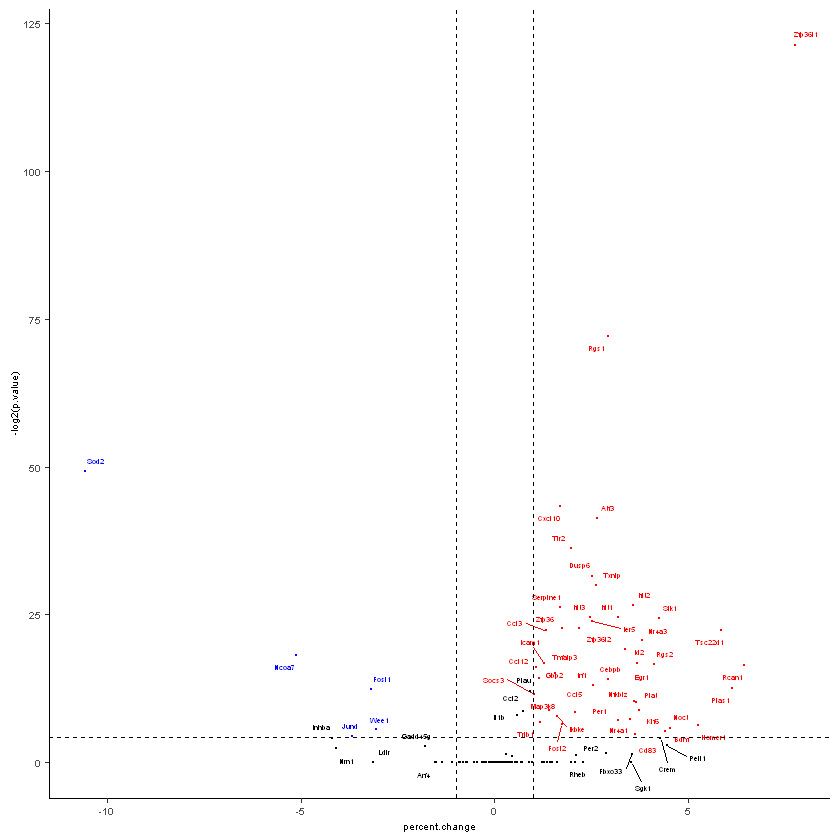

In [27]:
ggplot(PFC.pseudo.data, aes(x=PFC, y=p.value, label=gene, color=dir)) +
geom_text_repel(size=1.5) +
geom_point(size=0.3) +
theme_classic() +
    theme(axis.line = element_line(size=0.25), 
         plot.title=element_text(size=7),
         axis.text = element_text(size=6),
         axis.title = element_text(size=6),
         axis.ticks = element_line(size=0.25)) +
geom_vline(xintercept=c(-1, 1), col="black", linetype="dashed", size=0.1) +
geom_hline(yintercept=4.32, col="black",linetype="dashed", size=0.1) +
scale_color_manual(values=c("Down"="Blue","N"="Black","Up"="Red")) +
ylab('-log2(p.value)') +
xlab('percent.change') +
NoLegend()



Warning message:
"ggrepel: 68 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


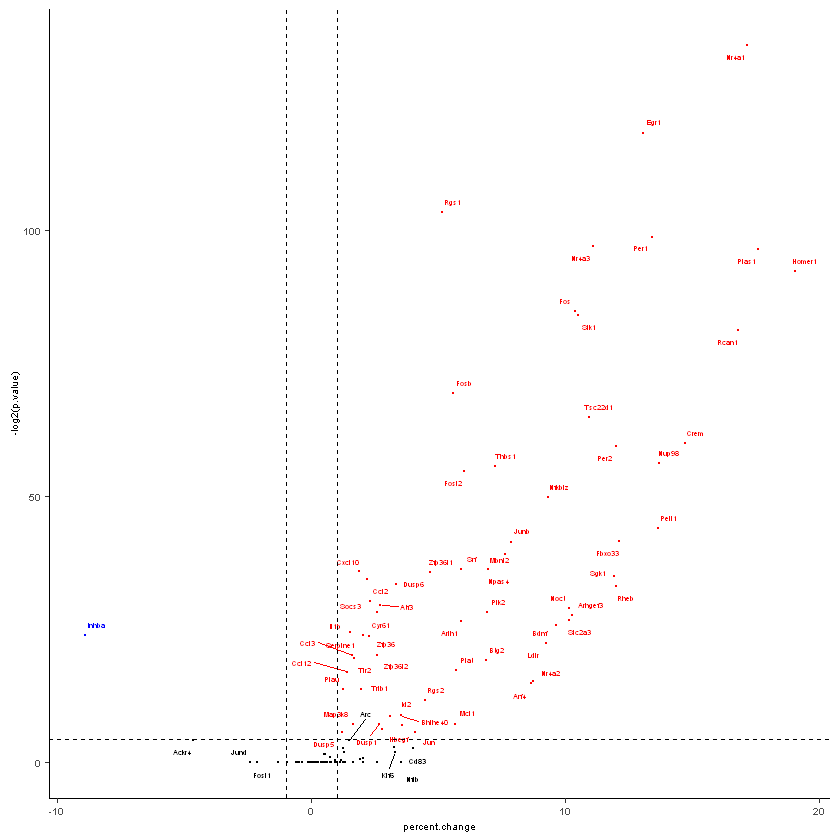

In [28]:
ggplot(NAc.pseudo.data, aes(x=NAc, y=p.value, label=gene, color=dir)) +
geom_text_repel(size=1.5) +
geom_point(size=0.3) +
theme_classic() +
    theme(axis.line = element_line(size=0.25), 
         plot.title=element_text(size=7),
         axis.text = element_text(size=6),
         axis.title = element_text(size=6),
         axis.ticks = element_line(size=0.25)) +
geom_vline(xintercept=c(-1, 1), col="black", linetype="dashed", size=0.1) +
geom_hline(yintercept=4.32, col="black",linetype="dashed", size=0.1) +
scale_color_manual(values=c("Down"="Blue","N"="Black","Up"="Red")) +
ylab('-log2(p.value)') +
xlab('percent.change') +
NoLegend()



Warning message:
"ggrepel: 81 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


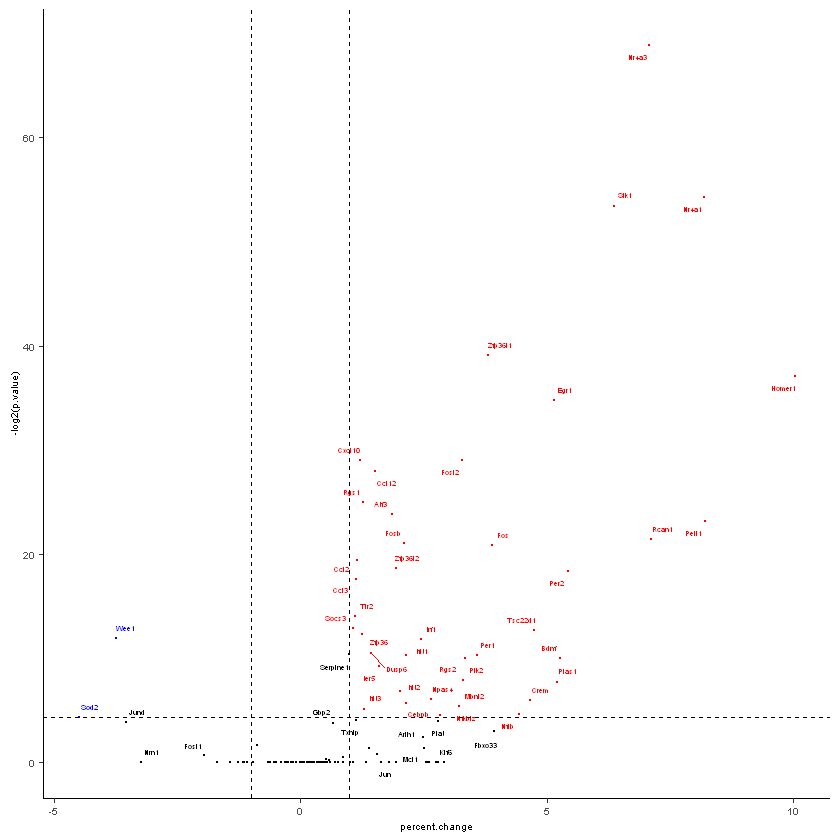

In [29]:
ggplot(LH.pseudo.data, aes(x=LH, y=p.value, label=gene, color=dir)) +
geom_text_repel(size=1.5) +
geom_point(size=0.3) +
theme_classic() +
    theme(axis.line = element_line(size=0.25), 
         plot.title=element_text(size=7),
         axis.text = element_text(size=6),
         axis.title = element_text(size=6),
         axis.ticks = element_line(size=0.25)) +
geom_vline(xintercept=c(-1, 1), col="black", linetype="dashed", size=0.1) +
geom_hline(yintercept=4.32, col="black",linetype="dashed", size=0.1) +
scale_color_manual(values=c("Down"="Blue","N"="Black","Up"="Red")) +
ylab('-log2(p.value)') +
xlab('percent.change') +
NoLegend()



### 1. Identifying IEGs that are variable across celltypes and across conditions

In [30]:
#manual shortlist of IEGs:
IEGs<-c("Fos", "Fosb", "Fosl1","Fosl2", "Jun", "Junb", "Jund", "Egr1", "Homer1", "Bdnf", "Crem", "Arc", "Myc")

We're going to focus on identifying variable IEGs based on the proportion of cells they're expressed in. This is because some IEGs may be too sparse to detect expression differences, so proprtion of cells may be a more sensitive measurement.

In [31]:
#predefined list of celltypes
Cell_type <- c("Glu1","CoEx1","Gaba1","DA1","DA2","Gaba2","Glu2","Glu3","Glu4","DA3","Glu5","Glu6","Glu7","CoEx2","CoEx3","Gaba3","Gaba4")

In [32]:
#splitting seurat object based on groups
VTA.YFP.sub <- subset(VTA.integrated, cells=colnames(VTA_YFP))
VTA.LH.sub <- subset(VTA.integrated, cells=colnames(VTA_LH))
VTA.NAc.sub <- subset(VTA.integrated, cells=colnames(VTA_NAc))
VTA.PFC.sub <- subset(VTA.integrated, cells=colnames(VTA_PFC))

In [33]:
#Pulling dfs of percent expressed across celltypes and conditions
YFP.df <- DotPlot(VTA.YFP.sub, features=IEGs, scale=FALSE)$data[c('features.plot','id','pct.exp')]
YFP.df <- reshape(YFP.df, idvar = "id", timevar='features.plot', direction = "wide")[2:14]
colnames(YFP.df) <- IEGs
rownames(YFP.df) <- Cell_type

LH.df <- DotPlot(VTA.LH.sub, features=IEGs, scale=FALSE)$data[c('features.plot','id','pct.exp')]
LH.df <- reshape(LH.df, idvar = "id", timevar='features.plot', direction = "wide")[2:14]
colnames(LH.df) <- IEGs
rownames(LH.df) <- Cell_type

NAc.df <- DotPlot(VTA.NAc.sub, features=IEGs, scale=FALSE)$data[c('features.plot','id','pct.exp')]
NAc.df <- reshape(NAc.df, idvar = "id", timevar='features.plot', direction = "wide")[2:14]
colnames(NAc.df) <- IEGs
rownames(NAc.df) <- Cell_type

PFC.df <- DotPlot(VTA.PFC.sub, features=IEGs, scale=FALSE)$data[c('features.plot','id','pct.exp')]
PFC.df <- reshape(PFC.df, idvar = "id", timevar='features.plot', direction = "wide")[2:14]
colnames(PFC.df) <- IEGs
rownames(PFC.df) <- Cell_type

In [34]:
filepath<-'./'

write.xlsx2(YFP.df,file=paste0(filepath, 'YFP_IEGpct.xlsx'))
write.xlsx2(PFC.df,file=paste0(filepath, 'PFC_IEGpct.xlsx'))
write.xlsx2(NAc.df,file=paste0(filepath, 'NAc_IEGpct.xlsx'))
write.xlsx2(LH.df,file=paste0(filepath, 'LH_IEGpct.xlsx'))

We will first take a measure of variance of each IEG across all celltypes to get a sense of genes expressed in a cell-type-specific manner

In [35]:
#Taking the SD of IEG expression among celltypes. Scaling for easier comparison across groups
YFP.var <- data.frame(apply(YFP.df, FUN=sd, MARGIN=2))
YFP.var<-scale(YFP.var)

LH.var <- data.frame(apply(LH.df, FUN=sd, MARGIN=2))
LH.var<-scale(LH.var)

PFC.var <- data.frame(apply(PFC.df, FUN=sd, MARGIN=2))
PFC.var<-scale(PFC.var)

NAc.var <- data.frame(apply(NAc.df, FUN=sd, MARGIN=2))
NAc.var<-scale(NAc.var)

In [36]:
#Now the means
YFP.mean <- data.frame(apply(YFP.df, FUN=mean, MARGIN=2))

LH.mean <- data.frame(apply(LH.df, FUN=mean, MARGIN=2))

PFC.mean <- data.frame(apply(PFC.df, FUN=mean, MARGIN=2))

NAc.mean <- data.frame(apply(NAc.df, FUN=mean, MARGIN=2))

In [37]:
#creating df celltype variances
celltype.var<-data.frame(cbind(YFP.mean, YFP.var))
colnames(celltype.var) <- c('mean','var')

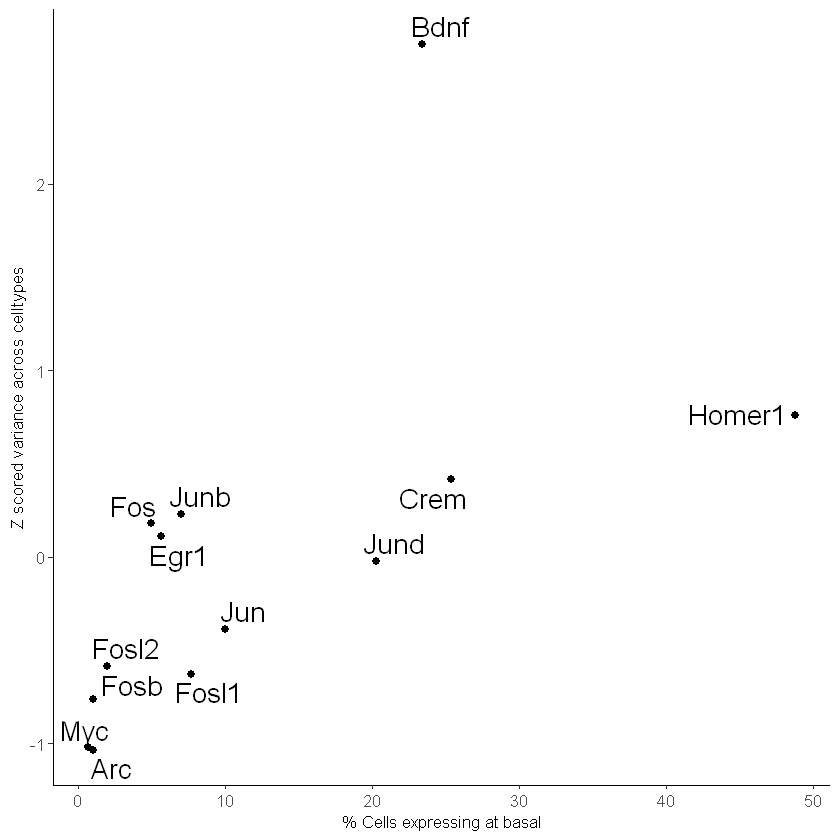

In [38]:
#plotting
ggplot(celltype.var, aes(x=mean, y=var, label=rownames(celltype.var)) ) +
    geom_point(size=2) +
    geom_text_repel(size=6) +
    theme_classic() +
    theme(axis.line = element_line(size=0.25), 
         plot.title=element_text(size=10),
         axis.text = element_text(size=10),
         axis.title = element_text(size=10),
         axis.ticks = element_line(size=0.25)) +
#ylim(c(NA,2))+
xlab('% Cells expressing at basal') +
ylab('Z scored variance across celltypes')

Now we will take the variance of each IEG across conditions so we can get an idea of genes that are induced by optogenetic stimulation

In [39]:
stim.var <- data.frame('YFP' = (apply(YFP.df, FUN=mean, MARGIN=2)),
           'LH' = (apply(LH.df, FUN=mean, MARGIN=2)),
           'PFC' = (apply(PFC.df, FUN=mean, MARGIN=2)),
           'NAc' = (apply(NAc.df, FUN=mean, MARGIN=2)))
stim.var <- data.frame(scale(apply(stim.var, FUN=sd, MARGIN=1)))
#stim.var

In [40]:
#df of the variance across conditions
condition.var <- cbind(YFP.mean, stim.var)
colnames(condition.var) <- c('mean','var')

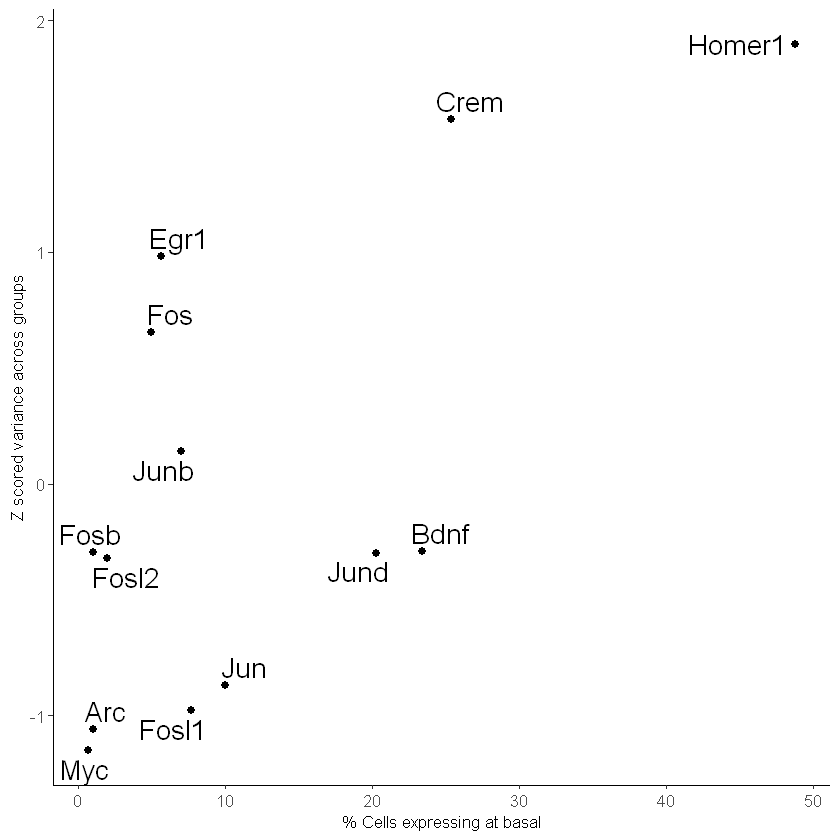

In [41]:
ggplot(condition.var, aes(x=mean, y=var, label=rownames(celltype.var)) ) +
    geom_point(size=2) +
    geom_text_repel(size=6) +
    theme_classic() +
    theme(axis.line = element_line(size=0.25), 
         plot.title=element_text(size=10),
         axis.text = element_text(size=10),
         axis.title = element_text(size=10),
         axis.ticks = element_line(size=0.25)) +
xlab('% Cells expressing at basal') +
ylab('Z scored variance across groups')

In [42]:
#plot celltype variability vs stim condition variability
bothvar<-cbind(celltype.var, condition.var)
colnames(bothvar)<-c('mean','celltype_var','mean2','condition_var')

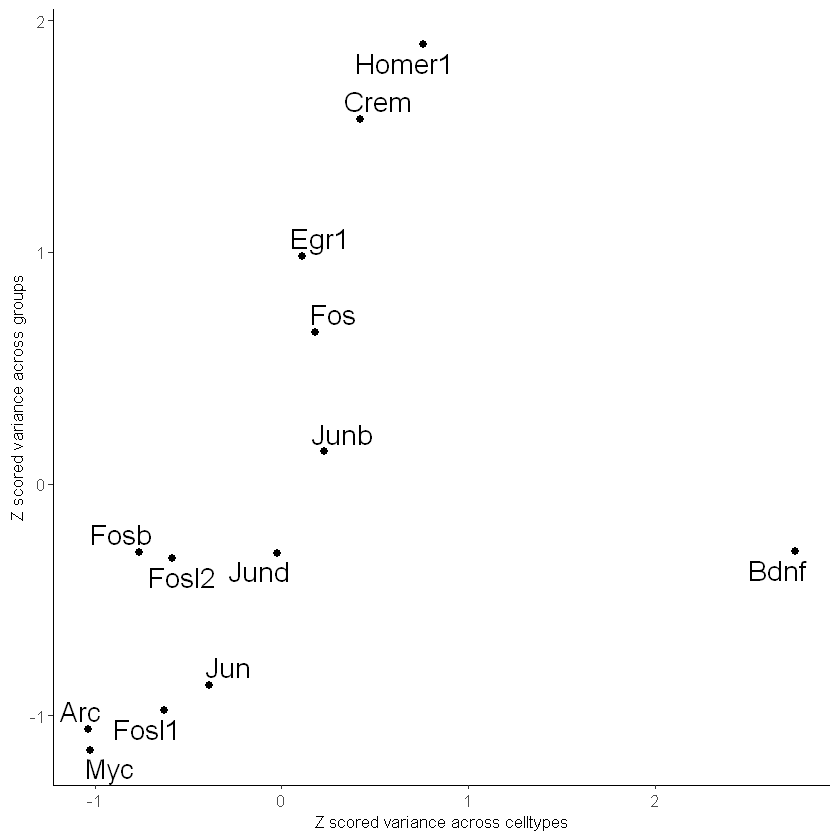

In [43]:
ggplot(bothvar, aes(x=celltype_var, y=condition_var, label=rownames(bothvar)) ) +
    geom_point(size=2) +
    geom_text_repel(size=6) +
    theme_classic() +
    theme(axis.line = element_line(size=0.25), 
         plot.title=element_text(size=10),
         axis.text = element_text(size=10),
         axis.title = element_text(size=10),
         axis.ticks = element_line(size=0.25)) +
xlab('Z scored variance across celltypes') +
ylab('Z scored variance across groups')

### 2. Identifying celltypes that are activated in each condition 

In [44]:
#Generating a df that contains only the shortlist of IEGs. We are going to use it to calculate the proportion of cells expressing each gene, then take the difference between conditions

VTA_LFG_sub <- subset(VTA.integrated, Fos > 0 | Fosb > 0 | Fosl1 > 0 | Fosl2 > 0 | Jun > 0 | Junb > 0 | Jund > 0 | Egr1 > 0 | Homer1 > 0 | Bdnf > 0 | Crem > 0 | Arc > 0 | Myc > 0)
VTA.LFG.table <- data.frame(table(Idents(VTA_LFG_sub), VTA_LFG_sub$stim))
VTA.integrated.table <- data.frame(table(Idents(VTA.integrated), VTA.integrated$stim))
VTA.LFG.table$Freq <- VTA.LFG.table$Freq/VTA.integrated.table$Freq

In [45]:
VTA.pct.YFP <- VTA.LFG.table[VTA.LFG.table$Var2 == 'VTA_YFP',]
VTA.pct.LH <- VTA.LFG.table[VTA.LFG.table$Var2 == 'VTA_LH',]
VTA.pct.NAc <- VTA.LFG.table[VTA.LFG.table$Var2 == 'VTA_NAc',]
VTA.pct.PFC <- VTA.LFG.table[VTA.LFG.table$Var2 == 'VTA_PFC',]

In [46]:
#Subtracting stim conditions from the control
LH.plot <- data.frame((VTA.pct.LH$Freq-VTA.pct.YFP$Freq))
LH.plot$id <- VTA.pct.LH$Var1
colnames(LH.plot) <- c("plot.change","id")

NAc.plot <- data.frame((VTA.pct.NAc$Freq-VTA.pct.YFP$Freq))
NAc.plot$id <- VTA.pct.NAc$Var1
colnames(NAc.plot) <- c("plot.change","id")

PFC.plot <- data.frame((VTA.pct.PFC$Freq-VTA.pct.YFP$Freq))
PFC.plot$id <- VTA.pct.PFC$Var1
colnames(PFC.plot) <- c("plot.change","id")

Now that we've calculated the proportion of neurons expressing each given gene, we can test for significance using the Fisher P Test

In [47]:
all <- data.frame(table(Idents(VTA.integrated), VTA.integrated$stim))
subset <- data.frame(table(Idents(VTA_LFG_sub), VTA_LFG_sub$stim))
obs <- cbind(subset, all$Freq)
colnames(obs) <- c("id",'stim','pos','all')
obs$neg <- obs$all - obs$pos

In [48]:
#creating test matrices
Fisher_p_IEG_LH <- vector()

for (i in 1:length(Cell_type)){
    
    con <- subset(obs, stim == 'VTA_YFP' & id == obs$id[i])
    stim <- subset(obs, stim == 'VTA_LH' & id == obs$id[i])

    test = matrix(c(con$pos, 
                    con$neg,
                    stim$pos,
                    stim$neg), ncol=2)
        
    test <- matrix(unlist(test), 2)
    temp_fisher <- fisher.test(test)
    Fisher_p_IEG_LH[i] <- -log2(temp_fisher$p.value )
    
}

In [49]:
Fisher_p_IEG_NAc <- vector()

for (i in 1:length(Cell_type)){
    
    con <- subset(obs, stim == 'VTA_YFP' & id == obs$id[i])
    stim <- subset(obs, stim == 'VTA_NAc' & id == obs$id[i])

    test = matrix(c(con$pos, 
                    con$neg,
                    stim$pos,
                    stim$neg), ncol=2)
        
    test <- matrix(unlist(test), 2)
    temp_fisher <- fisher.test(test)
    Fisher_p_IEG_NAc[i] <- -log2(temp_fisher$p.value )
    
}

In [50]:
Fisher_p_IEG_PFC <- vector()

for (i in 1:length(Cell_type)){
    
    con <- subset(obs, stim == 'VTA_YFP' & id == obs$id[i])
    stim <- subset(obs, stim == 'VTA_PFC' & id == obs$id[i])

    test = matrix(c(con$pos, 
                    con$neg,
                    stim$pos,
                    stim$neg), ncol=2)
        
    test <- matrix(unlist(test), 2)
    temp_fisher <- fisher.test(test)
    Fisher_p_IEG_PFC[i] <- -log2(temp_fisher$p.value) 
    
}

In [51]:
NAc.plot <- cbind(NAc.plot, Fisher_p_IEG_NAc)
NAc.plot$sig <- ifelse(NAc.plot$Fisher_p_IEG_NAc > -log2(0.05), "red", "black")
LH.plot <- cbind(LH.plot, Fisher_p_IEG_LH)
LH.plot$sig <- ifelse(LH.plot$Fisher_p_IEG_LH > -log2(0.05), "red", "black")
PFC.plot <- cbind(PFC.plot, Fisher_p_IEG_PFC)
PFC.plot$sig <- ifelse(PFC.plot$Fisher_p_IEG_PFC > -log2(0.05), "red", "black")

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


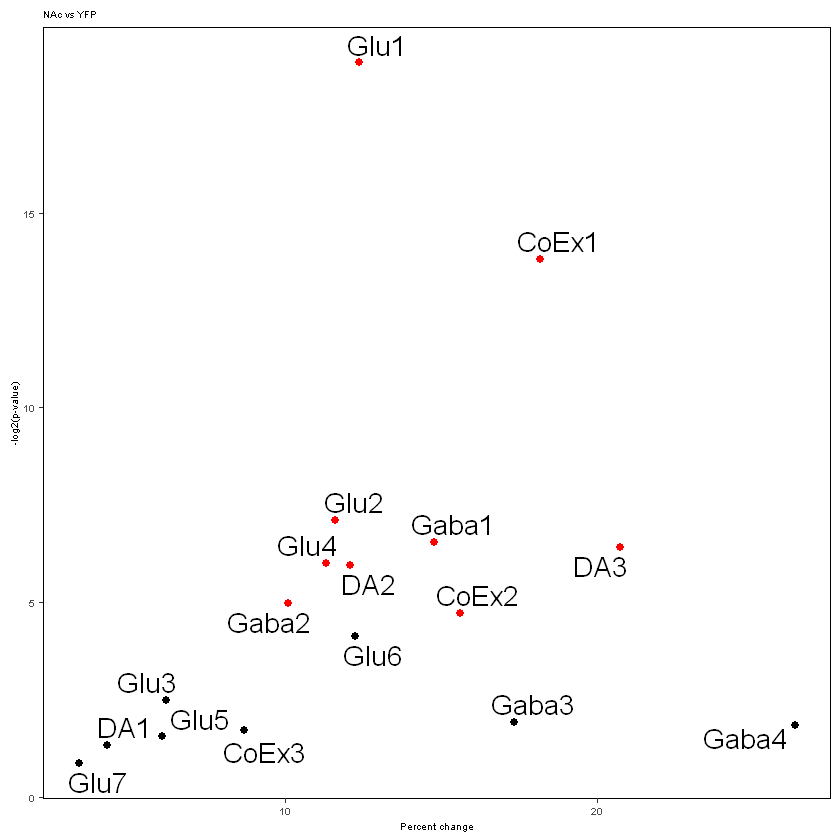

In [52]:
ggplot(NAc.plot, aes(x=plot.change*100, y=Fisher_p_IEG_NAc, label=id)) +
    ggtitle("NAc vs YFP") +
    geom_point(size=2, color=NAc.plot$sig) + 
    scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black")) +
    geom_text_repel(size=6) +
    theme_classic() + 
    theme(axis.line = element_blank(), 
         plot.title=element_text(size=6),
         panel.background = element_rect(colour = "black", size=.25, fill=NA),
         axis.text = element_text(size=6),
         axis.title = element_text(size=6),
         axis.ticks = element_line(size=0.25))+
    xlab("Percent change") + 
    ylab("-log2(p-value)") #+
    #geom_vline(xintercept = 0, linetype='dashed', size=.25)


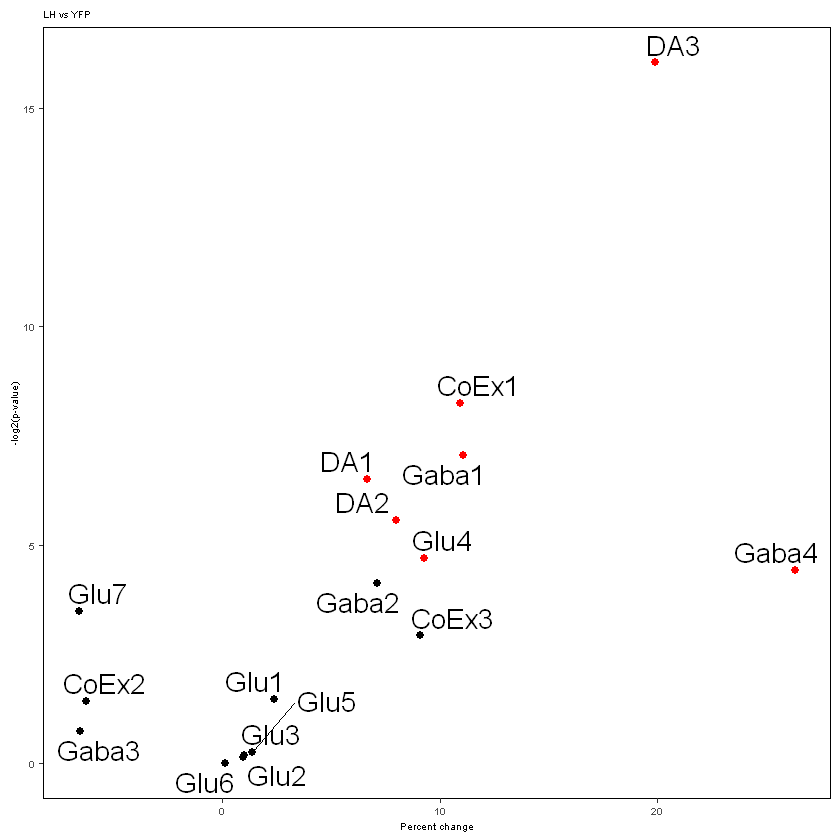

In [53]:
ggplot(LH.plot, aes(x=plot.change*100, y=Fisher_p_IEG_LH, label=id)) +
    ggtitle("LH vs YFP") +
    geom_point(size=2, color=LH.plot$sig) + 
    scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black")) +
    geom_text_repel(size=6) +
    theme_classic() + 
    theme(axis.line = element_blank(), 
         plot.title=element_text(size=6),
         panel.background = element_rect(colour = "black", size=.25, fill=NA),
         axis.text = element_text(size=6),
         axis.title = element_text(size=6),
         axis.ticks = element_line(size=0.25))+
    xlab("Percent change") + 
    ylab("-log2(p-value)") #+
    #geom_vline(xintercept = 0, linetype='dashed', size=.25)


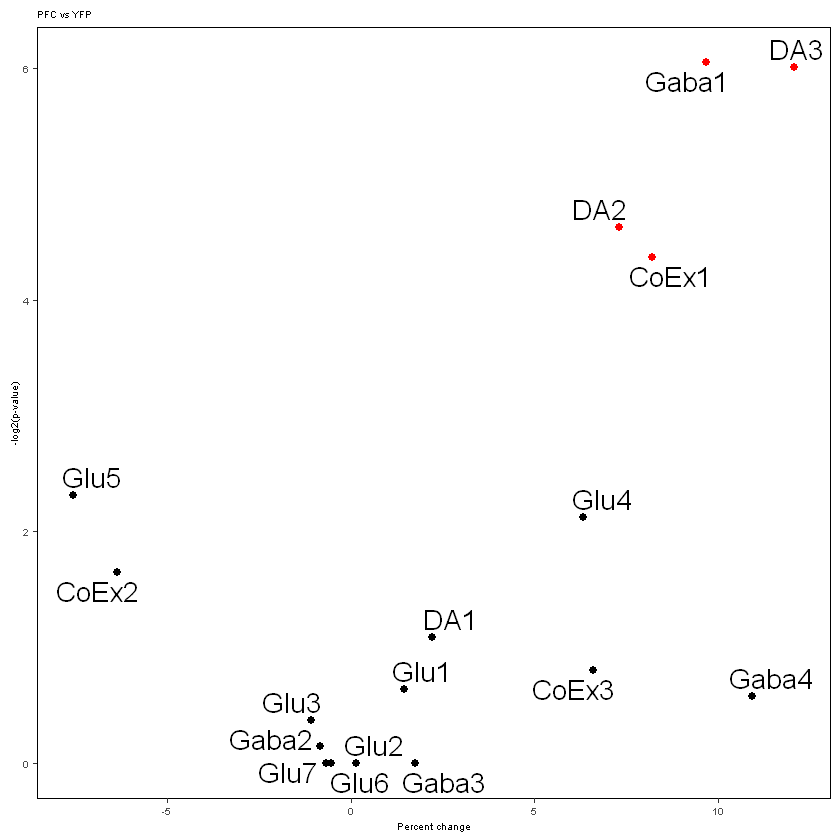

In [54]:
ggplot(PFC.plot, aes(x=plot.change*100, y=Fisher_p_IEG_PFC, label=id)) +
    ggtitle("PFC vs YFP") +
    geom_point(size=2, color=PFC.plot$sig) + 
    scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black")) +
    geom_text_repel(size=6) +
    theme_classic() + 
    theme(axis.line = element_blank(), 
         plot.title=element_text(size=6),
         panel.background = element_rect(colour = "black", size=.25, fill=NA),
         axis.text = element_text(size=6),
         axis.title = element_text(size=6),
         axis.ticks = element_line(size=0.25))+
    xlab("Percent change") + 
    ylab("-log2(p-value)") #+
    #geom_vline(xintercept = 0, linetype='dashed', size=.25)


## Correlation heatmaps

In [55]:
AllIEGs <- read.xlsx("./IEG list.xlsx",sheetIndex=1,header=FALSE)
  
AllIEGlist<-AllIEGs$X1 

#Or use short list
#AllIEGlist<-c("Fos", "Fosb", "Fosl1","Fosl2", "Jun", "Junb", "Jund", "Egr1", "Homer1", "Bdnf", "Crem", "Arc", "Myc")

In [56]:
#Renaming clusters to condense into DA, Glu, GABA, CoEx

new.ident <- c("Glu","CoEx","Gaba","DA","DA","Gaba","Glu","Glu","Glu","DA","Glu","Glu","Glu","CoEx","CoEx","Gaba","Gaba")
names(x = new.ident) <- levels(x =VTA.integrated)
VTA.integrated<- RenameIdents(object =VTA.integrated, new.ident)

In [57]:
#Checking number of cells in each new cluster. Make sure this matches sum of original clusters.
table(Idents(VTA.integrated))


 Glu CoEx Gaba   DA 
4243 1373 1714 2006 

In [58]:
#Get expression data for YFP and for stim of your choice. Calc log2FC for each gene.
#removing genes not expressed in all groups in all conditions

con <- (data.frame(AverageExpression(subset(VTA.integrated, cells=colnames(VTA_YFP)), features=AllIEGlist, assay='RNA')[1]))
stim_PFC <- (data.frame(AverageExpression(subset(VTA.integrated, cells=colnames(VTA_PFC)), features=AllIEGlist, assay='RNA')[1]))
stim_LH <- (data.frame(AverageExpression(subset(VTA.integrated, cells=colnames(VTA_LH)), features=AllIEGlist, assay='RNA')[1]))
stim_NAc <- (data.frame(AverageExpression(subset(VTA.integrated, cells=colnames(VTA_NAc)), features=AllIEGlist, assay='RNA')[1]))

#eliminate rows from each dataframe containing zeroes
row_sub = apply(con, 1, function(row) all(row !=0 ))
con<-con[row_sub,]
                
row_sub = apply(stim_PFC, 1, function(row) all(row !=0 ))
stim_PFC<-stim_PFC[row_sub,]
                
row_sub = apply(stim_NAc, 1, function(row) all(row !=0 ))
stim_NAc<-stim_NAc[row_sub,]
                
row_sub = apply(stim_LH, 1, function(row) all(row !=0 ))
stim_LH<-stim_LH[row_sub,]

#get list of rownames from each dataframe and find intersecting list
keeperscon<-rownames(con)
keepersPFC<-rownames(stim_PFC)
keepersNAc<-rownames(stim_NAc)
keepersLH<-rownames(stim_LH)

keepers<-Reduce(intersect, list(keeperscon, keepersPFC, keepersNAc, keepersLH))

#keeping only rows with no zeroes anywhere
con<-con[keepers,]
stim_PFC<-stim_PFC[keepers,]
stim_NAc<-stim_NAc[keepers,]
stim_LH<-stim_LH[keepers,]

deltaPFC<-log2(stim_PFC) - log2(con)
deltaLH<-log2(stim_LH) - log2(con)
deltaNAc<-log2(stim_NAc) - log2(con)

In [59]:
#Define columns of subtracted dataframe
Cell_type_2 <- c('Glu','CoEx','Gaba','DA')

colnames(deltaPFC) <- Cell_type_2
colnames(deltaLH) <- Cell_type_2
colnames(deltaNAc) <- Cell_type_2

#for raw data, not log2FC
colnames(stim_PFC)<-Cell_type_2
colnames(stim_NAc)<-Cell_type_2
colnames(stim_LH)<-Cell_type_2

In [60]:
deltaPFC$id <- rownames(deltaPFC)
deltaNAc$id <- rownames(deltaNAc)
deltaLH$id <- rownames(deltaLH)

In [61]:
#generating dataframes that will be used for correlation

NAc_expr<-deltaNAc[1:4]
PFC_expr<-deltaPFC[1:4]
LH_expr<-deltaLH[1:4]

colnames(NAc_expr)<-c('NAc.Glu','NAc.CoEx','NAc.GABA','NAc.DA')
colnames(PFC_expr)<-c('PFC.Glu','PFC.CoEx','PFC.GABA','PFC.DA')
colnames(LH_expr)<-c('LH.Glu','LH.CoEx','LH.GABA','LH.DA')


In [62]:
#combine expression data
allinputs<-cbind(PFC_expr, NAc_expr, LH_expr)
#write.xlsx2(allinputs, './alliegs_allinputs.xlsx')

In [63]:
#run correlation analysis

allinputs.cor<-cor(allinputs, use = "complete.obs", method = 'pearson')
#write.xlsx2(allinputs.cor, './correlation.xlsx')

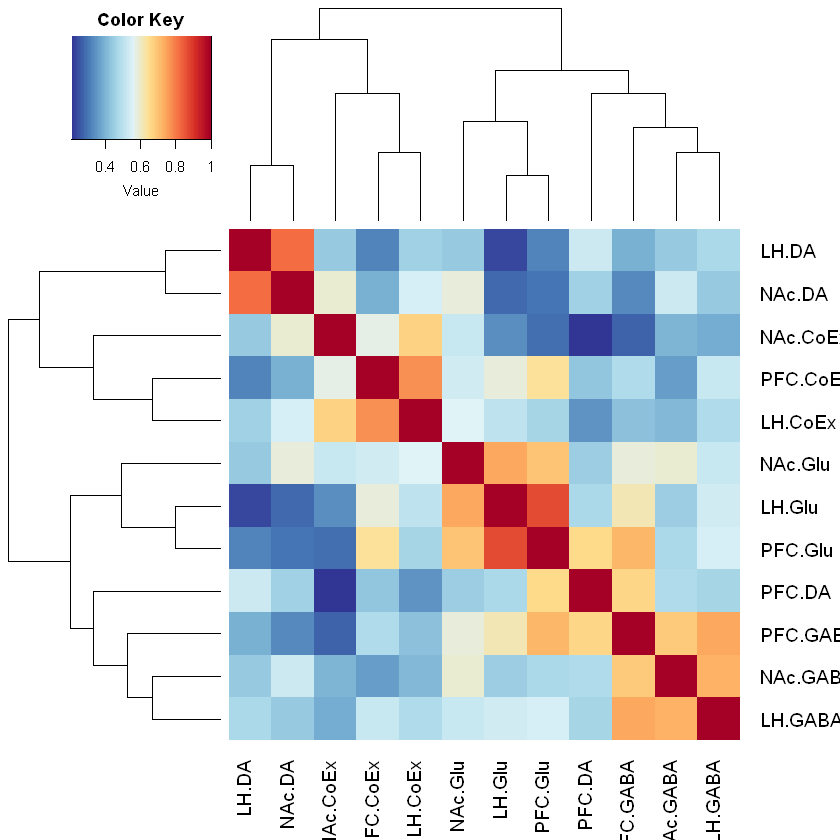

In [64]:
mybreaks<-c(seq(0,1, length.out=101))
palette <- colorRampPalette(rev(brewer.pal(10, "RdYlBu")))(100)

heatmap.2(x=allinputs.cor, symm=TRUE, col=palette, key=TRUE, trace='none', revC=TRUE, density.info='none' 

       )

### Normalized expression of shortlist IEGs

In [65]:
#list of IEGs
IEGs<-c('Fos', 'Fosb', 'Fosl1', 'Fosl2', 'Jun', 'Junb', 'Jund', 'Egr1', 'Homer1', 'Bdnf', 'Crem', 'Arc', 'Myc')

In [66]:
#Renaming clusters to condense into DA, Glu, GABA, CoEx (if you didn't run this already above)
new.ident <- c("Glu","CoEx","Gaba","DA","DA","Gaba","Glu","Glu","Glu","DA","Glu","Glu","Glu","CoEx","CoEx","Gaba","Gaba")
names(x = new.ident) <- levels(x =VTA.integrated)
VTA.integrated<- RenameIdents(object =VTA.integrated, new.ident)

Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"
Warning message:
"Cannot find identity NA"


In [67]:
#Checking number of cells in each new cluster. Make sure this matches sum of original clusters.
table(Idents(VTA.integrated))


 Glu CoEx Gaba   DA 
4243 1373 1714 2006 

In [68]:
#Get expression data for YFP and for stims. Calc log2FC from YFP.

con <- (data.frame(AverageExpression(subset(VTA.integrated, cells=colnames(VTA_YFP)), features=IEGs, assay='RNA')[1]))
stim_PFC <- (data.frame(AverageExpression(subset(VTA.integrated, cells=colnames(VTA_PFC)), features=IEGs, assay='RNA')[1]))
stim_LH <- (data.frame(AverageExpression(subset(VTA.integrated, cells=colnames(VTA_LH)), features=IEGs, assay='RNA')[1]))
stim_NAc <- (data.frame(AverageExpression(subset(VTA.integrated, cells=colnames(VTA_NAc)), features=IEGs, assay='RNA')[1]))

deltaPFC13<-log2(stim_PFC) - log2(con)
deltaLH13<-log2(stim_LH) - log2(con)
deltaNAc13<-log2(stim_NAc) - log2(con)

In [69]:
#Define columns of subtracted dataframe
Cell_type_2 <- c('Glu','CoEx','GABA','DA')

colnames(deltaPFC13) <- Cell_type_2
colnames(deltaLH13) <- Cell_type_2
colnames(deltaNAc13) <- Cell_type_2

In [70]:
#normalizing

deltaPFC13<-as.data.frame(apply(deltaPFC13,2,function(x){x/max(x)}))
deltaNAc13<-as.data.frame(apply(deltaNAc13,2,function(x){x/max(x)}))
deltaLH13<-as.data.frame(apply(deltaLH13,2,function(x){x/max(x)}))

In [71]:
deltaPFC13$id <- rownames(deltaPFC13)
deltaNAc13$id <- rownames(deltaNAc13)
deltaLH13$id <- rownames(deltaLH13)

deltaPFC13 <- melt(deltaPFC13)
deltaNAc13 <- melt(deltaNAc13)
deltaLH13 <- melt(deltaLH13)

deltaPFC13$variable <- factor(deltaPFC13$variable, levels=c('DA','Glu','GABA','CoEx'))
deltaNAc13$variable <- factor(deltaNAc13$variable, levels=c('DA','Glu','GABA','CoEx'))
deltaLH13$variable <- factor(deltaLH13$variable, levels=c('DA','Glu','GABA','CoEx'))

Using id as id variables

Using id as id variables

Using id as id variables



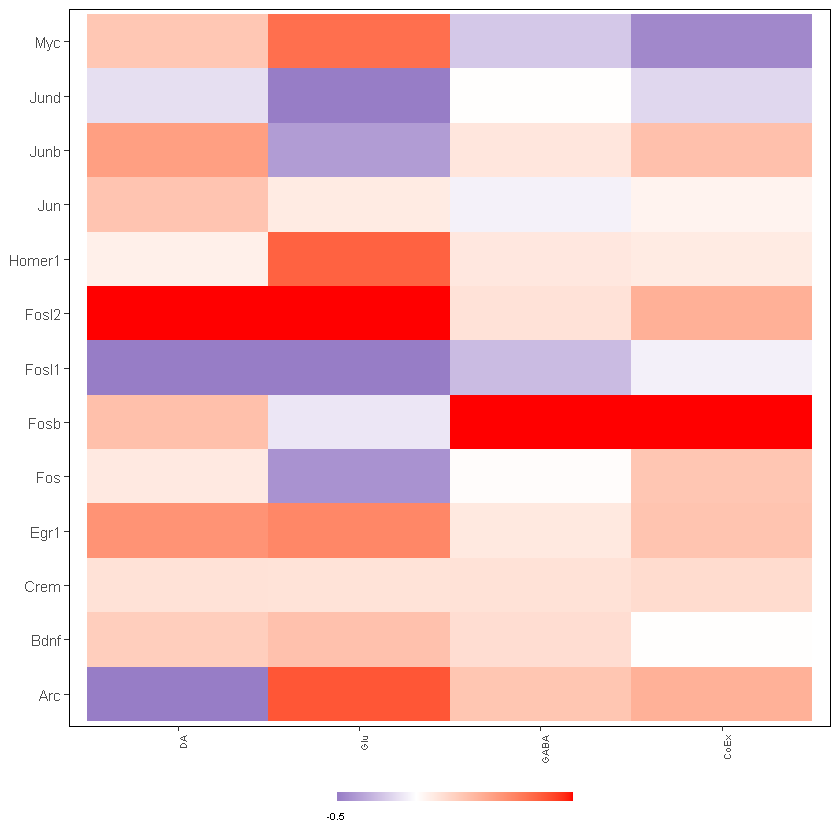

In [72]:
#Make heatplot

ggplot(deltaPFC13, aes(x=variable, y=id, fill=value)) +
theme_classic()+
theme(axis.text.x=element_text( size=6, angle=90, hjust=1),
            plot.title = element_text(size=6),
            panel.background = element_rect(colour = "black", size=.25, fill=NA),
            axis.line.y = element_blank(),
            axis.line.x=element_blank(),
            axis.title.y = element_blank(),
            axis.ticks.x = element_line(size=0.25),
            axis.title.x = element_blank(),
            legend.key.height= unit(0.2, 'cm'), 
            legend.key.width = unit(1.0, 'cm'),
            legend.position = "bottom",
            legend.text = element_text(size=6),
            legend.title = element_blank())+
    geom_tile() +
    scale_fill_gradient2(limits=c(-0.5, 1), breaks=seq(-0.5,1,by=10),low = "darkblue",mid="white",midpoint=0,high = "red",oob=squish) #
#ggsave('./PFC all clusters expression heatmap norm to column.pdf',width=5, height=10)

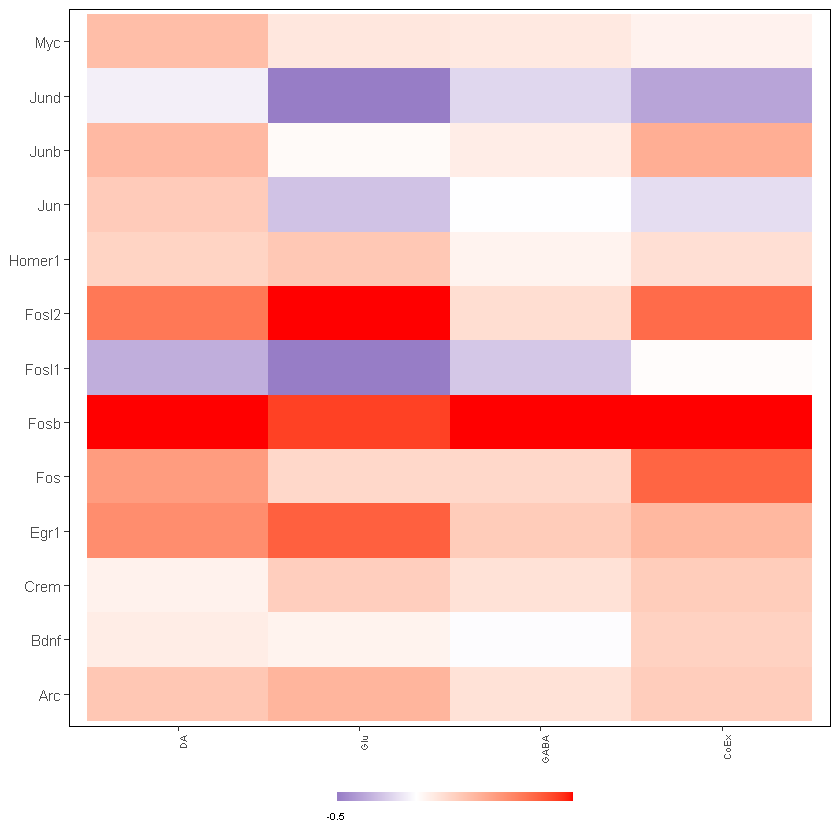

In [73]:
#Make heatplot

ggplot(deltaNAc13, aes(x=variable, y=id, fill=value)) +
theme_classic()+
theme(axis.text.x=element_text( size=6, angle=90, hjust=1),
            plot.title = element_text(size=6),
            panel.background = element_rect(colour = "black", size=.25, fill=NA),
            axis.line.y = element_blank(),
            axis.line.x=element_blank(),
            axis.title.y = element_blank(),
            axis.ticks.x = element_line(size=0.25),
            axis.title.x = element_blank(),
            legend.key.height= unit(0.2, 'cm'), 
            legend.key.width = unit(1.0, 'cm'),
            legend.position = "bottom",
            legend.text = element_text(size=6),
            legend.title = element_blank())+
    geom_tile() +
    scale_fill_gradient2(limits=c(-0.5, 1), breaks=seq(-0.5,1,by=10),low = "darkblue",mid="white",midpoint=0,high = "red",oob=squish) #
#ggsave('./NAc all clusters expression heatmap norm to column.pdf',width=5, height=10)

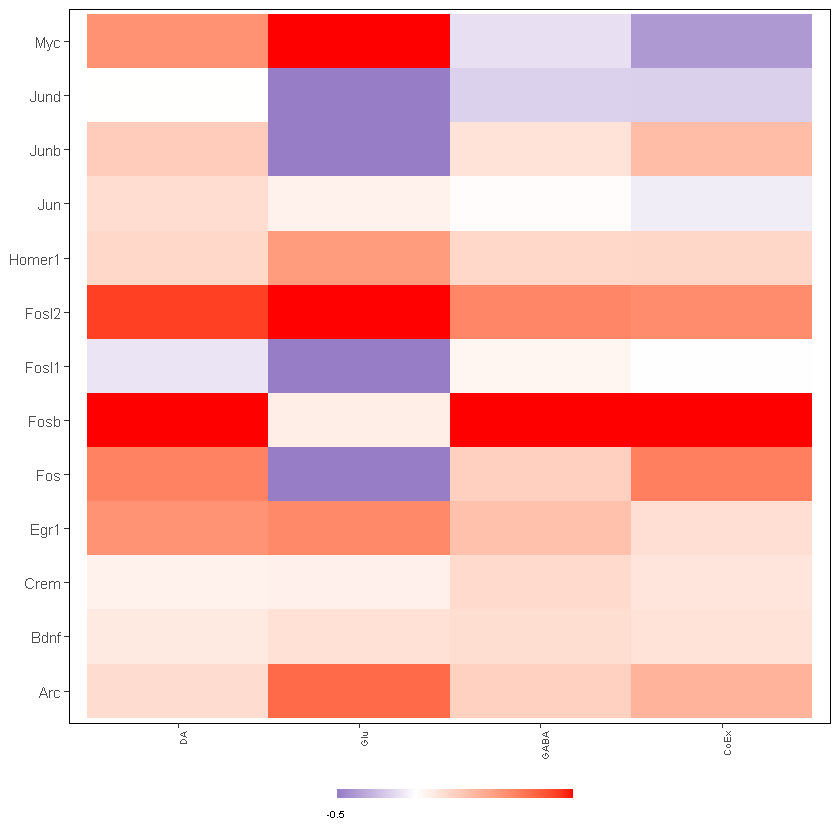

In [74]:
#Make heatplot

ggplot(deltaLH13, aes(x=variable, y=id, fill=value)) +
theme_classic()+
theme(axis.text.x=element_text( size=6, angle=90, hjust=1),
            plot.title = element_text(size=6),
            panel.background = element_rect(colour = "black", size=.25, fill=NA),
            axis.line.y = element_blank(),
            axis.line.x=element_blank(),
            axis.title.y = element_blank(),
            axis.ticks.x = element_line(size=0.25),
            axis.title.x = element_blank(),
            legend.key.height= unit(0.2, 'cm'), 
            legend.key.width = unit(1.0, 'cm'),
            legend.position = "bottom",
            legend.text = element_text(size=6),
            legend.title = element_blank())+
    geom_tile() +
    scale_fill_gradient2(limits=c(-0.5, 1), breaks=seq(-0.5,1,by=10),low = "darkblue",mid="white",midpoint=0,high = "red",oob=squish) #
#ggsave('./LH all clusters expression heatmap norm to column.pdf',width=5, height=10)